In [1]:
import numpy as np
import pandas as pd
import pandasql as pdsql
from datetime import datetime

pysql = lambda q: pdsql.sqldf(q, globals())

features = pd.read_csv('data/amico-features-export.csv.gz', compression='gzip')
features.sort_values(by=['dump_id'],inplace=True)
features.set_index(features['dump_id'],inplace=True)

metadata = pd.read_csv('data/amico-export.csv.gz', compression='gzip')
metadata.sort_values(by=['dump_id'],inplace=True)
metadata['date'] = pd.to_datetime(metadata['date'])
metadata = metadata[metadata['dump_id'].isin(features['dump_id'])]
metadata.set_index(metadata['dump_id'],inplace=True)

print ("Number of rows in metadata =", len(metadata))
print ("Number of rows in features =", len(features))


Number of rows in metadata = 121545
Number of rows in features = 121545


In [2]:
# metadata = metadata.loc[metadata['type'] == 'DMG']
print ("Number of rows in metadata =", len(metadata))

Number of rows in metadata = 121545


In [3]:
data = features.join(metadata[['dump_id','date','md5','host','type','max_tavs','max_avs']], how='inner', rsuffix='_d')
data.sort_values(by=['dump_id'],inplace=True)

print ("Number of rows in data after join =", len(data))

Number of rows in data after join = 121545


In [4]:
from collections import Counter

def filter_count(count_dict, th=0):
    new_dict = dict()
    for k in count_dict:
        if count_dict[k] > th:
            new_dict[k] = count_dict[k]
    return new_dict

md5_count = Counter(data['md5'])
host_count = Counter(data['host'])

md5_count_filtered = dict()
host_count_filtered = dict()

# md5_count_filtered = filter_count(md5_count,100)
# host_count_filtered = filter_count(host_count,1000)

In [5]:
# filtering out popular md5s and hosts
dataset = data.copy()
print ("Number of rows =", len(dataset))
dataset = dataset.loc[~dataset['md5'].isin(md5_count_filtered.keys())]
print ("Number of remaining rows =", len(dataset))
dataset = dataset.loc[~dataset['host'].isin(host_count_filtered.keys())]
print ("Number of remaining rows =", len(dataset))
dataset = dataset.loc[~dataset['max_tavs'].isnull()]
print ("Number of remaining rows =", len(dataset))


Number of rows = 121545
Number of remaining rows = 121545
Number of remaining rows = 121545
Number of remaining rows = 112472


In [6]:
def label_downloads(avs_count, avs_count1, threshold):
    avs_count = list(avs_count)
    avs_count1 = list(avs_count1)
    labels = ['benign']*len(avs_count)
    for i in range(len(avs_count)):
        if avs_count[i] >= threshold : 
            labels[i] = 'malware'
        elif ((avs_count1[i] > 0) and (avs_count[i] < 2)) :
            labels[i] = 'unknown'
    return labels

threshold = 2
avs_count = dataset['max_tavs']
avs_count1 = dataset['max_avs']
dataset['avs5'] = label_downloads(avs_count, avs_count1, threshold)

dataset = dataset.loc[dataset['avs5'] != 'unknown']
print ("Number of remaining rows =", len(dataset))

print ("Dataset: instances =",dataset.shape[0], "  features =",dataset.shape[1])

print (dataset.dtypes)

Number of remaining rows = 94699
Dataset: instances = 94699   features = 79
dump_id                                      int64
raw_dump_num_av_labels                     float64
raw_dump_trusted_av_labels                 float64
vt_month_shelf                             float64
corrupt                                     object
host_malware_downloads                     float64
host_suspicious_downloads                  float64
host_benign_downloads                      float64
host_total_downloads                       float64
host_malware_ratio                         float64
host_suspicious_ratio                      float64
host_benign_ratio                          float64
host_avg_av_labels                         float64
host_avg_trusted_labels                    float64
host_unknown_hashes                        float64
host_total_hashes                          float64
host_unknown_hash_ratio                    float64
twold_malware_downloads                    float64
twold_

In [7]:
labels_count = Counter(list(dataset['avs5']))
print ("Labels count:", labels_count)

type_count = Counter(list(dataset['type']))
print ("Type count:", type_count)

Labels count: Counter({'benign': 90148, 'malware': 4551})
Type count: Counter({'EXE': 36846, 'JAR': 31615, 'APK': 16071, 'DMG': 10167})


In [8]:
# One-hot-encoding
cfs = ['extension_class','type']
for fn in cfs:
    ohe_feat = pd.get_dummies(dataset[fn], prefix=fn)
    dataset = dataset.drop([fn], axis=1)
    dataset = pd.concat((dataset, ohe_feat), axis=1)

print ("Dataset: instances =",dataset.shape[0], "  features =",dataset.shape[1])

Dataset: instances = 94699   features = 87


In [9]:
trainining_end_date = '2017-04-01'

training_data = dataset[dataset['date']<trainining_end_date]
test_data = dataset[dataset['date']>=trainining_end_date]

print ("Number of test data rows =", len(training_data))
print ("Number of training data rows =", len(test_data))

labels_count = Counter(list(training_data['avs5']))
print ("Training labels count:", labels_count)

labels_count = Counter(list(test_data['avs5']))
print ("Test labels count:", labels_count)


Number of test data rows = 36451
Number of training data rows = 58248
Training labels count: Counter({'benign': 34443, 'malware': 2008})
Test labels count: Counter({'benign': 55705, 'malware': 2543})


In [10]:
print (dataset.dtypes)

dump_id                                  int64
raw_dump_num_av_labels                 float64
raw_dump_trusted_av_labels             float64
vt_month_shelf                         float64
corrupt                                 object
host_malware_downloads                 float64
host_suspicious_downloads              float64
host_benign_downloads                  float64
host_total_downloads                   float64
host_malware_ratio                     float64
host_suspicious_ratio                  float64
host_benign_ratio                      float64
host_avg_av_labels                     float64
host_avg_trusted_labels                float64
host_unknown_hashes                    float64
host_total_hashes                      float64
host_unknown_hash_ratio                float64
twold_malware_downloads                float64
twold_suspicious_downloads             float64
twold_benign_downloads                 float64
twold_total_downloads                  float64
twold_malware

In [71]:
train = training_data.copy()
test = test_data.copy()

train_Y = list(train['avs5'])
test_Y  = list(test['avs5'])
remove_cols = ['vt_month_shelf', 'raw_dump_trusted_av_labels', 'raw_dump_num_av_labels', 'dump_id','corrupt','sha1','host','url_struct','dump_id_d','date','md5','host_d','max_tavs','max_avs','avs5']
remove_cols = remove_cols + ['type_APK','type_DMG','type_JAR','type_EXE']
#remove_cols = remove_cols + ['extension_class_common_ext', 'extension_class_common_fake', 'extension_class_no_ext', 'extension_class_no_url','extension_class_other_ext','extension_class_unknown_ext']
remove_cols = remove_cols + ['url_struct_malware_downloads','url_struct_total_downloads','url_struct_distinct_sha1s','server_ip_avg_av_labels','server_ip_avg_trusted_labels','hash_daily_dump_rate_per_client']
remove_cols = remove_cols + ['server_ip_malware_ratio','server_ip_suspicious_ratio','server_ip_benign_ratio','server_ip_unknown_hash_ratio','host_unknown_hashes','host_total_hashes']


for c in remove_cols:
    del train[c]
    del test[c]

#all_cols = list(dataset.columns[0:])

#remove_cols = ['host_malware_downloads','host_suspicious_downloads','host_malware_ratio','host_suspicious_ratio','twold_malware_ratio','twold_suspicious_ratio','server_ip_malware_ratio','server_ip_benign_ratio','bgp_unknown_hash_ratio','estimated_clients_with_same_hash','referer_exists','url_length','url_malware_downloads','directory_depth']

#partial_cols = [x for x in all_cols if x not in remove_cols]

#for c in partial_cols:
#    del train[c]
#    del test[c]

print ("Train: instances =",train.shape[0], "  features =",train.shape[1])
print ("Test:  instances =",test.shape[0], "  features =",test.shape[1]) 


Train: instances = 36451   features = 56
Test:  instances = 58248   features = 56


In [72]:
# train[100:110]

In [73]:
from sklearn.ensemble import *

# imputation of missing values by substituting -1 for compatibility with RF implementation
train.fillna(-1,inplace=True)
clf = RandomForestClassifier(n_estimators=100, random_state=12345)
clf.fit(train, train_Y)
print (clf.feature_importances_)

[1.22368210e-01 8.05064933e-03 1.01264589e-02 2.07568126e-03
 1.09104130e-01 1.65826583e-02 2.40004849e-02 6.08122582e-02
 1.10964852e-01 1.71435177e-04 6.46222161e-02 9.14458251e-03
 1.43565872e-02 1.06818953e-03 9.68994329e-02 4.66850795e-02
 4.46357340e-02 1.39530435e-01 4.63264526e-02 2.25462165e-04
 5.47673438e-04 2.07549331e-04 1.28751286e-03 6.95921653e-04
 3.37277882e-04 6.41665742e-04 3.16449464e-04 4.44064306e-04
 6.89637404e-04 1.02089112e-03 1.77902911e-03 1.11942285e-03
 3.25982630e-03 5.09609484e-03 2.06283876e-03 1.15155402e-02
 5.55177542e-03 6.16657602e-04 8.30200008e-04 7.00387506e-04
 3.48238479e-04 4.78355169e-04 4.85515092e-04 8.16518843e-03
 1.27332361e-04 1.24608744e-02 2.80636698e-03 3.39490360e-03
 2.95717208e-04 3.35594054e-04 3.71441054e-04 6.15990606e-08
 9.64155493e-04 2.63209365e-03 4.73100412e-04 1.89656180e-04]


In [74]:
from sklearn.metrics import accuracy_score, roc_curve, auc


    

# imputation of missing values by substituting -1 for compatibility with RF implementation
test.fillna(-1,inplace=True)

Y_hat = clf.predict(test)
acc = accuracy_score(test_Y,Y_hat)

scores = pd.DataFrame(clf.predict_proba(test))
scores.columns = ['benign','malware']

#print(len(scores['malware']))
fpr, tpr, th = roc_curve(test_Y, scores['malware'], pos_label='malware')

['vt_month_shelf', 'raw_dump_trusted_av_labels', 'raw_dump_num_av_labels', 'dump_id', 'corrupt', 'sha1', 'host', 'url_struct', 'dump_id_d', 'date', 'md5', 'host_d', 'max_tavs', 'max_avs', 'avs5', 'type_APK', 'type_DMG', 'type_JAR', 'type_EXE', 'url_struct_malware_downloads', 'url_struct_total_downloads', 'url_struct_distinct_sha1s', 'server_ip_avg_av_labels', 'server_ip_avg_trusted_labels', 'hash_daily_dump_rate_per_client', 'server_ip_malware_ratio', 'server_ip_suspicious_ratio', 'server_ip_benign_ratio', 'server_ip_unknown_hash_ratio', 'host_unknown_hashes', 'host_total_hashes']


In [75]:
def compute_partial_auc(fpr, tpr, fpr_max):
    partial_fpr = [fpr[i] for i in range(len(fpr)) if fpr[i] <= fpr_max]
    partial_tpr = [tpr[i] for i in range(len(fpr)) if fpr[i] <= fpr_max]
    partial_fpr = partial_fpr + [fpr_max]
    partial_tpr = partial_tpr + [tpr[-1]]
    partial_auc = (auc(partial_fpr, partial_tpr) / (fpr_max))
    #print(partial_fpr)
    return partial_auc

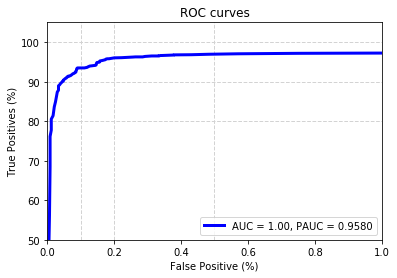

In [76]:
import matplotlib.pyplot as plt

def plot_ROC(fpr, tpr, fpr_max=0.01, title='ROC curves'):
    plt.figure()
    lw = 3

    plt.plot([0, 100], [100, 100], color='lightgray', lw=1, linestyle='--')
    plt.plot([0, 100], [90, 90], color='lightgray', lw=1, linestyle='--')
    plt.plot([0, 100], [80, 80], color='lightgray', lw=1, linestyle='--')
    plt.plot([1.0, 1.0], [50, 105], color='lightgray', lw=1, linestyle='--')
    plt.plot([0.5, 0.5], [50, 105], color='lightgray', lw=1, linestyle='--')
    plt.plot([0.2, 0.2], [50, 105], color='lightgray', lw=1, linestyle='--')
    plt.plot([0.1, 0.1], [50, 105], color='lightgray', lw=1, linestyle='--')

    pauc = compute_partial_auc(fpr, tpr, fpr_max)
    plt.plot(fpr*100, tpr*100, color='blue', lw=lw, label='AUC = %.2f, PAUC = %.4f' % (auc(fpr, tpr), pauc))

    plt.xlim([0.0, fpr_max*100])
    plt.ylim([50, 105])
    plt.xlabel('False Positive (%)')
    plt.ylabel('True Positives (%)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig('data/no_type_feature.pdf')
    #plt.savefig('data/all_features.pdf')

    plt.show()
   
    
    
plot_ROC(fpr,tpr)